In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)

os.chdir('..')

In [2]:
from utils import metrics
from utils.ensembles import EnsembleCPDModel, CusumEnsembleCPDModel

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset

import yaml

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload
%matplotlib inline

comet_ml is installed but `COMET_API_KEY` is not set.


In [3]:
class OutputDataset(Dataset):
    """Fake dataset to store pre-computed all models' outputs for MMD model evaluation."""

    def __init__(self, test_out_bank, test_uncertainties_bank, test_labels_bank):
        super().__init__()
        
        # every prediction is (batch_size, seq_len)
        self.test_out = list(torch.vstack(test_out_bank))
                
        self.test_labels = list(torch.vstack(test_labels_bank))
        
        self.test_uncertainties = list(torch.vstack(test_uncertainties_bank))  

    def __len__(self):
        return len(self.test_labels)

    def __getitem__(self, idx):
        return (self.test_out[idx], self.test_uncertainties[idx]), self.test_labels[idx]
    
class AllModelsOutputDataset(Dataset):
    """Fake dataset to store pre-computed all models' outputs for MMD model evaluation."""

    def __init__(self, test_out_bank, test_labels_bank):
        super().__init__()
        
        # every prediction is (n_models, batch_size, seq_len)
        self.test_out = list(torch.hstack(test_out_bank).transpose(0, 1))
                
        self.test_labels = list(torch.vstack(test_labels_bank))
        
    def __len__(self):
        return len(self.test_labels)

    def __getitem__(self, idx):
        return self.test_out[idx], self.test_labels[idx]

# BCE HAR

In [5]:
model_type = "seq2seq"
experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, 'r') as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["loss_type"] = "bce"
args_config["num_workers"] = 2
args_config["learning"]["gpus"] = 1
args_config["learning"]["epochs"] = 100

In [6]:
path_to_models_folder = "saved_models/bce/human_activity/full_sample"

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

In [7]:
test_dataset = ens_bce.test_dataset
test_dataloader = DataLoader(test_dataset, batch_size = args_config["learning"]["batch_size"], shuffle=True)

seq_batch, labels_batch = next(iter(test_dataloader))
seq_batch = seq_batch.to("cuda")

In [18]:
# collecting outputs
test_out_bank, test_uncertainties_bank, test_labels_bank = metrics.collect_model_predictions_on_set(
    ens_bce,
    test_dataloader,
    model_type="ensemble",
    device="cpu"
)

out_dataset = OutputDataset(test_out_bank, test_uncertainties_bank, test_labels_bank)
out_dataloader = DataLoader(out_dataset, batch_size=128, shuffle=False)

(preds, stds), labels = out_dataset[0]
preds.shape, stds.shape, labels.shape

 10%|▉         | 2/21 [00:00<00:01, 15.56it/s]

Collectting model's outputs


100%|██████████| 21/21 [00:01<00:00, 17.79it/s]


(torch.Size([20]), torch.Size([20]), torch.Size([20]))

In [9]:
metrics.compute_stds(
    ens_bce,
    test_dataloader,
    windows_list=[1, 2, 3, 4],
    verbose=True,
    device="cpu"
);

  5%|▍         | 1/21 [00:00<00:02,  8.34it/s]

Computing model's outputs...


100%|██████████| 21/21 [00:01<00:00, 15.85it/s]


Window: 1
CP stds list:
Mean = 0.03207298447961587, number is 1141
Normal stds list:
Mean = 0.016499603666940796, number is 1304
p_val analytical = 5.307543209593889e-16, p_val permutational = 0.0
Stds are not statistically equal
--------------------------------------------------
Window: 2
CP stds list:
Mean = 0.026167749764975635, number is 1141
Normal stds list:
Mean = 0.016379096082922904, number is 1268
p_val analytical = 3.2219743264956137e-07, p_val permutational = 0.0
Stds are not statistically equal
--------------------------------------------------
Window: 3
CP stds list:
Mean = 0.02317281357256743, number is 1141
Normal stds list:
Mean = 0.01636149097055964, number is 1224
p_val analytical = 0.0004631365226327131, p_val permutational = 0.0003
Stds are not statistically equal
--------------------------------------------------
Window: 4
CP stds list:
Mean = 0.02135552822915865, number is 1141
Normal stds list:
Mean = 0.016414368928879347, number is 1173
p_val analytical = 0.012

In [24]:
norm_sigma = 0.0164996
cp_sigma = 0.032072

global_sigma = "local_whole"

lambda_null = 1. / cp_sigma ** 2
#lambda_inf = 1. / norm_sigma ** 2

lambda_inf = None

half_wnd = 1

In [25]:
ens_bce_new_crit_noncond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="new_criteria",
    conditional=False,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_bce_new_crit_noncond.load_models_list(path_to_models_folder)

_ = ens_bce_new_crit_noncond.predict(seq_batch)
new_crit_noncond = ens_bce_new_crit_noncond.normal_to_change_stats.detach().cpu()

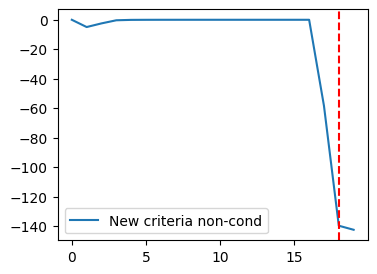

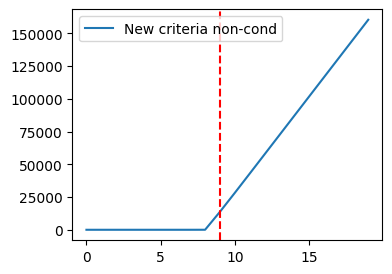

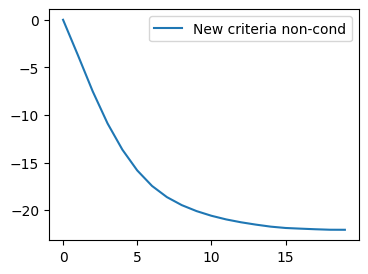

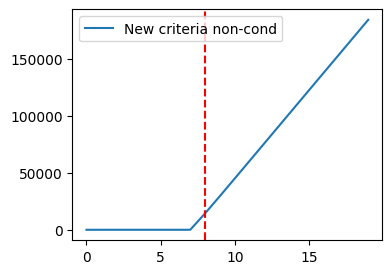

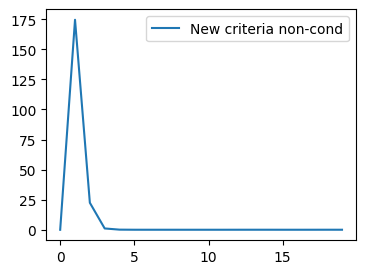

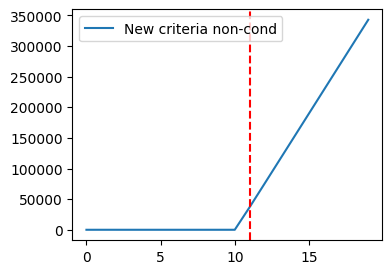

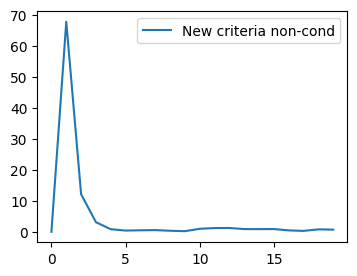

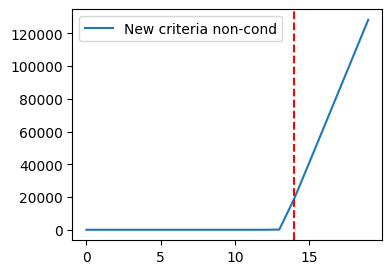

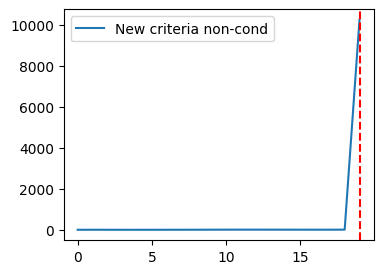

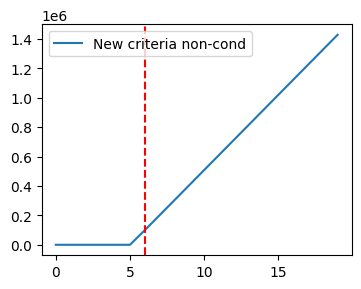

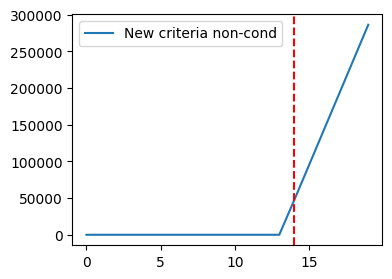

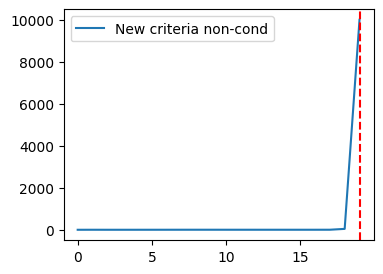

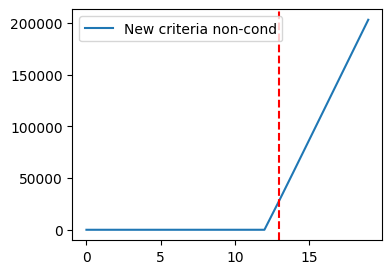

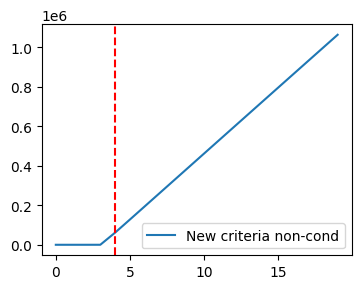

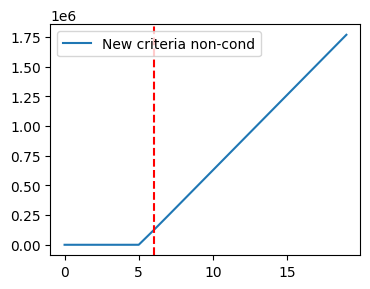

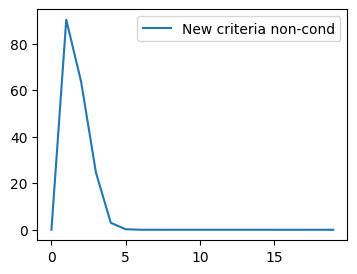

In [26]:
for IDX in range(16):
    change_idx = labels_batch[IDX].detach().cpu().numpy().argmax()

    plt.figure(figsize=(4, 3))
    #plt.plot(cusum_old[IDX], label="Old CUSUM")
    #plt.plot(cusum_correct_noncond[IDX], label="Correct CUSUM non-cond")
    #plt.plot(cusum_correct_cond[IDX], label="New CUSUM cond")
    plt.plot(new_crit_noncond[IDX], label="New criteria non-cond")
    #plt.plot(new_crit_cond[IDX], label="New criteria cond")

    if change_idx > 0:
        plt.axvline(x = change_idx, c="red", linestyle="--")
    plt.legend()
    plt.show()

In [27]:
cusum_threshold_list = np.linspace(0, 100000, 300)

metrics.evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="new_criteria",
    conditional=False,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 300/300 [09:52<00:00,  1.98s/it]

Results for best threshold = 334.44816053511704
AUDC: 0.0, Time to FA: 11.4353, DD: 0.4615, F1: 0.9708, Cover: 0.9798, Max Cover: 0.9798
Max F1 with margin 1: 0.9607
Max F1 with margin 2: 0.964
Max F1 with margin 4: 0.9667


In [31]:
cusum_threshold_list = np.linspace(0, 1000, 100)

metrics.evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="new_criteria",
    conditional=False,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 100/100 [03:16<00:00,  1.97s/it]

Results for best threshold = 232.3232323232323
AUDC: 0.0, Time to FA: 11.371, DD: 0.4226, F1: 0.9745, Cover: 0.981, Max Cover: 0.981
Max F1 with margin 1: 0.9631
Max F1 with margin 2: 0.9667
Max F1 with margin 4: 0.9686


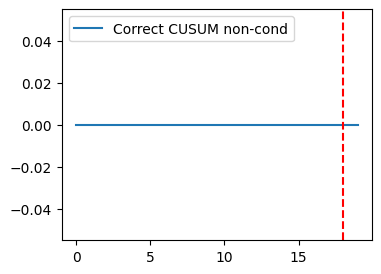

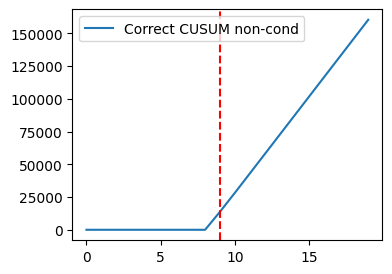

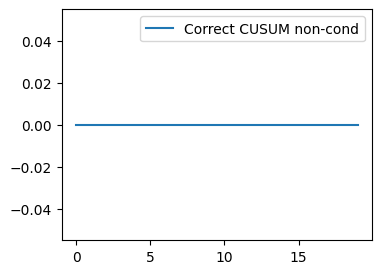

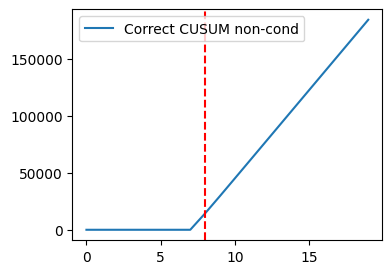

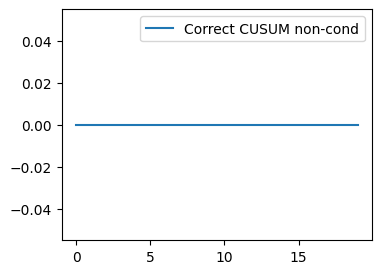

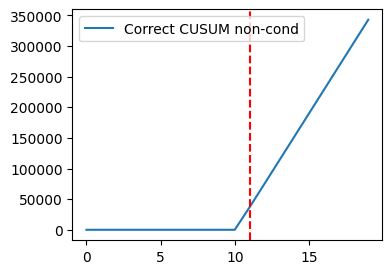

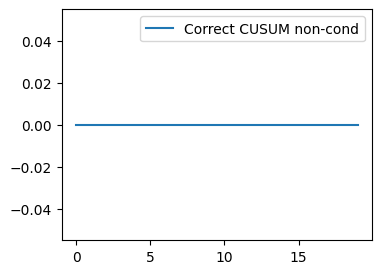

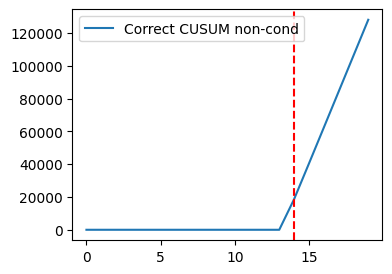

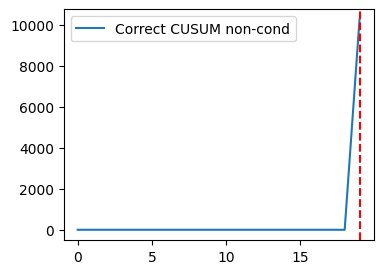

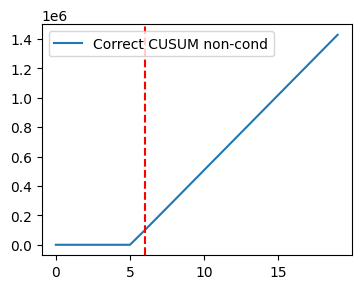

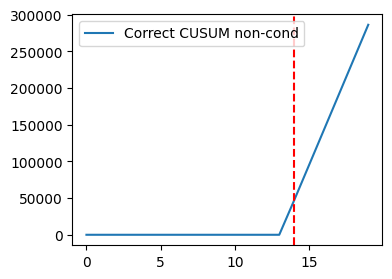

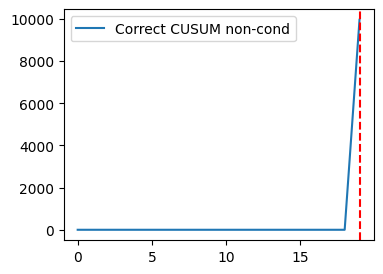

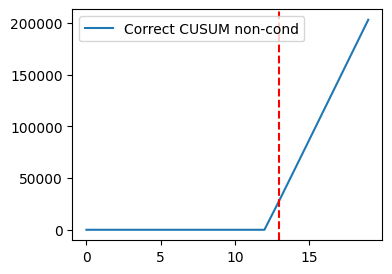

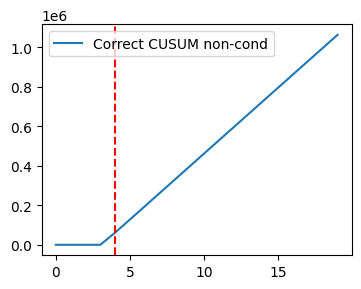

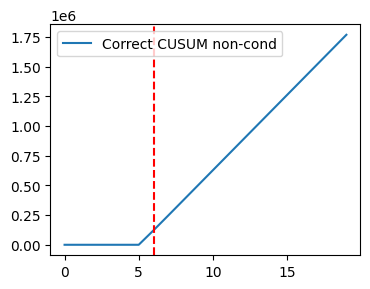

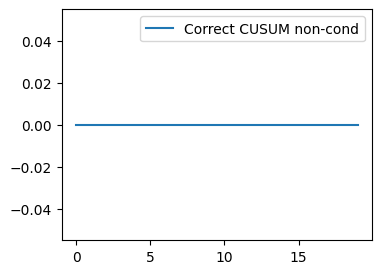

In [15]:
ens_bce_correct_noncond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma="local_whole",
    seed=0,
    cusum_threshold=10,
    cusum_mode="correct",
    conditional=False,
    #lambda_null=lambda_null,
    #lambda_inf=lambda_inf,
    half_wnd=1,
)
ens_bce_correct_noncond.load_models_list(path_to_models_folder)

_ = ens_bce_correct_noncond.predict(seq_batch)
cusum_correct_noncond = ens_bce_correct_noncond.normal_to_change_stats.detach().cpu()

for IDX in range(16):
    change_idx = labels_batch[IDX].detach().cpu().numpy().argmax()

    plt.figure(figsize=(4, 3))
    plt.plot(cusum_correct_noncond[IDX], label="Correct CUSUM non-cond")

    if change_idx > 0:
        plt.axvline(x = change_idx, c="red", linestyle="--")
    plt.legend()
    plt.show()

In [16]:
cusum_threshold_list = np.linspace(0, 50000, 200)

metrics.evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="correct",
    conditional=False,
    global_sigma="local_whole",
    #lambda_null=lambda_null,
    #lambda_inf=lambda_inf,
    half_wnd=1,
    device="cpu",
    verbose=True,
);

100%|██████████| 200/200 [06:38<00:00,  1.99s/it]

Results for best threshold = 0.0
AUDC: 0.0, Time to FA: 11.0262, DD: 0.0935, F1: 0.9909, Cover: 0.9938, Max Cover: 0.9938
Max F1 with margin 1: 0.9865
Max F1 with margin 2: 0.9896
Max F1 with margin 4: 0.9914


In [17]:
cusum_threshold_list = np.linspace(0, 100, 50)

metrics.evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="correct",
    conditional=False,
    global_sigma="local_whole",
    #lambda_null=lambda_null,
    #lambda_inf=lambda_inf,
    half_wnd=1,
    device="cpu",
    verbose=True,
);

100%|██████████| 50/50 [01:36<00:00,  1.93s/it]

Results for best threshold = 4.081632653061225
AUDC: 0.0, Time to FA: 11.0995, DD: 0.1197, F1: 0.9944, Cover: 0.9948, Max Cover: 0.9948
Max F1 with margin 1: 0.9874
Max F1 with margin 2: 0.9909
Max F1 with margin 4: 0.9927


# BCE-SGLD HAR

# TS-CP HAR

In [4]:
model_type = "tscp"
experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, 'r') as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["num_workers"] = 2
args_config["learning"]["gpus"] = 1
args_config["learning"]["epochs"] = 100

In [5]:
path_to_models_folder = f"saved_models/tscp/human_activity/window_{args_config['model']['window']}"

ens_tscp = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_tscp.load_models_list(path_to_models_folder)

In [6]:
test_dataset = ens_tscp.test_dataset
test_dataloader = DataLoader(test_dataset, batch_size = args_config["learning"]["batch_size"], shuffle=True)

seq_batch, labels_batch = next(iter(test_dataloader))

In [7]:
# collecting outputs
test_out_bank, test_uncertainties_bank, test_labels_bank = metrics.collect_model_predictions_on_set(
    ens_tscp,
    test_dataloader,
    model_type="ensemble",
    device="cpu"
)

out_dataset = OutputDataset(test_out_bank, test_uncertainties_bank, test_labels_bank)
out_dataloader = DataLoader(out_dataset, batch_size=128, shuffle=False)

(preds, stds), labels = out_dataset[0]
preds.shape, stds.shape, labels.shape

  0%|          | 0/168 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 168/168 [01:41<00:00,  1.65it/s]


(torch.Size([20]), torch.Size([20]), torch.Size([20]))

In [8]:
metrics.compute_stds(
    ens_tscp,
    test_dataloader,
    windows_list=[1, 2, 3, 4],
    verbose=True,
    device="cpu"
);

  0%|          | 0/168 [00:00<?, ?it/s]

Computing model's outputs...


100%|██████████| 168/168 [01:56<00:00,  1.44it/s]


Window: 1
CP stds list:
Mean = 0.18081591965945512, number is 1141
Normal stds list:
Mean = 0.013837257669655646, number is 1304
p_val analytical = 0.0, p_val permutational = 0.0
Stds are not statistically equal
--------------------------------------------------
Window: 2
CP stds list:
Mean = 0.14318844215417123, number is 1141
Normal stds list:
Mean = 0.011605343895439905, number is 1268
p_val analytical = 0.0, p_val permutational = 0.0
Stds are not statistically equal
--------------------------------------------------
Window: 3
CP stds list:
Mean = 0.1274656238769794, number is 1141
Normal stds list:
Mean = 0.011478933919100813, number is 1224
p_val analytical = 0.0, p_val permutational = 0.0
Stds are not statistically equal
--------------------------------------------------
Window: 4
CP stds list:
Mean = 0.1197553883138538, number is 1141
Normal stds list:
Mean = 0.012360929820639813, number is 1173
p_val analytical = 0.0, p_val permutational = 0.0
Stds are not statistically equal
-

In [8]:
norm_sigma = 0.01384
cp_sigma = 0.18081

global_sigma = norm_sigma

lambda_null = 1. / cp_sigma ** 2
lambda_inf = 1. / norm_sigma ** 2
half_wnd = 1

In [9]:
ens_tscp_old = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="old",
    conditional=True,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_tscp_old.load_models_list(path_to_models_folder)

_ = ens_tscp_old.predict(seq_batch)
cusum_old = ens_tscp_old.normal_to_change_stats.detach().cpu()

# ----------------------------------------------------------- #

ens_tscp_correct_noncond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="correct",
    conditional=False,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_tscp_correct_noncond.load_models_list(path_to_models_folder)
_ = ens_tscp_correct_noncond.predict(seq_batch)
cusum_correct_noncond = ens_tscp_correct_noncond.normal_to_change_stats.detach().cpu()

# ----------------------------------------------------------- #

ens_tscp_correct_cond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="correct",
    conditional=True,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_tscp_correct_cond.load_models_list(path_to_models_folder)

_ = ens_tscp_correct_cond.predict(seq_batch)
cusum_correct_cond = ens_tscp_correct_cond.normal_to_change_stats.detach().cpu()

# ----------------------------------------------------------- #

ens_tscp_new_crit_noncond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="new_criteria",
    conditional=False,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_tscp_new_crit_noncond.load_models_list(path_to_models_folder)

_ = ens_tscp_new_crit_noncond.predict(seq_batch)
new_crit_noncond = ens_tscp_new_crit_noncond.normal_to_change_stats.detach().cpu()

# ----------------------------------------------------------- #

ens_tscp_new_crit_cond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="new_criteria",
    conditional=True,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_tscp_new_crit_cond.load_models_list(path_to_models_folder)
_ = ens_tscp_new_crit_cond.predict(seq_batch)
new_crit_cond = ens_tscp_new_crit_cond.normal_to_change_stats.detach().cpu()

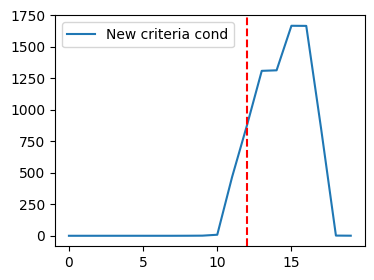

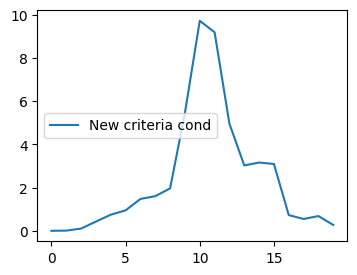

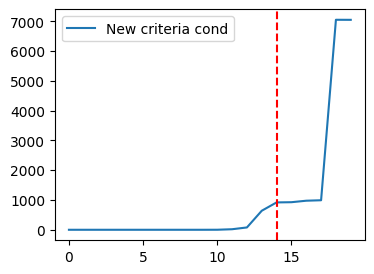

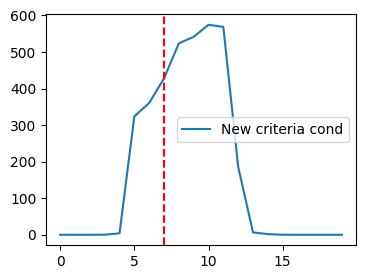

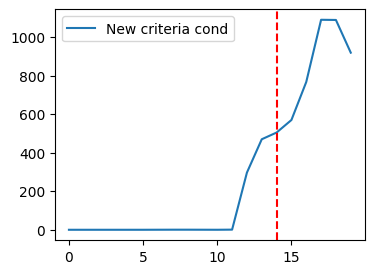

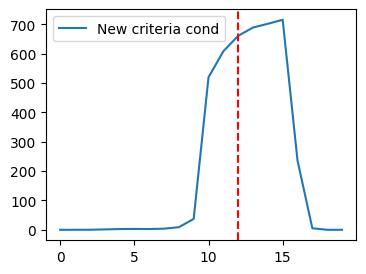

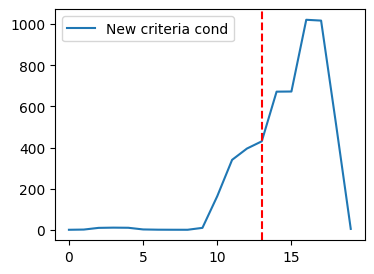

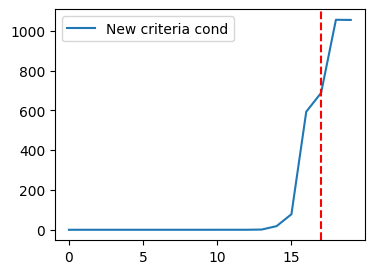

In [14]:
for IDX in range(8):
    change_idx = labels_batch[IDX].detach().cpu().numpy().argmax()

    plt.figure(figsize=(4, 3))
    #plt.plot(cusum_old[IDX], label="Old CUSUM")
    #plt.plot(cusum_correct_noncond[IDX], label="Correct CUSUM non-cond")
    #plt.plot(cusum_correct_cond[IDX], label="New CUSUM cond")
    #plt.plot(new_crit_noncond[IDX], label="New criteria non-cond")
    plt.plot(new_crit_cond[IDX], label="New criteria cond")

    if change_idx > 0:
        plt.axvline(x = change_idx, c="red", linestyle="--")
    plt.legend()
    plt.show()

In [11]:
cusum_threshold_list = np.linspace(0, 10, 50)

metrics.evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="old",
    conditional=True,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 50/50 [01:52<00:00,  2.26s/it]

Results for best threshold = 4.8979591836734695
AUDC: 0.0, Time to FA: 11.1571, DD: 1.6552, F1: 0.7349, Cover: 0.8735, Max Cover: 0.8735
Max F1 with margin 1: 0.7522
Max F1 with margin 2: 0.8083
Max F1 with margin 4: 0.8617


In [16]:
cusum_threshold_list = np.linspace(500, 2000, 100)

metrics.evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="correct",
    conditional=False,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 100/100 [03:43<00:00,  2.23s/it]

Results for best threshold = 1590.909090909091
AUDC: 0.0, Time to FA: 10.5236, DD: 0.9319, F1: 0.9208, Cover: 0.906, Max Cover: 0.906
Max F1 with margin 1: 0.8133
Max F1 with margin 2: 0.9022
Max F1 with margin 4: 0.9287


In [17]:
cusum_threshold_list = np.linspace(0, 500, 100)

metrics.evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="correct",
    conditional=True,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 100/100 [03:42<00:00,  2.23s/it]

Results for best threshold = 5.05050505050505
AUDC: 0.0, Time to FA: 10.5542, DD: 0.9843, F1: 0.9193, Cover: 0.9021, Max Cover: 0.9021
Max F1 with margin 1: 0.8163
Max F1 with margin 2: 0.9053
Max F1 with margin 4: 0.9272


In [20]:
cusum_threshold_list = np.linspace(1900, 5000, 100)

metrics.evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="new_criteria",
    conditional=False,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 100/100 [03:43<00:00,  2.24s/it]

Results for best threshold = 2213.131313131313
AUDC: 0.0, Time to FA: 10.5438, DD: 0.9895, F1: 0.9262, Cover: 0.9006, Max Cover: 0.9006
Max F1 with margin 1: 0.8097
Max F1 with margin 2: 0.9022
Max F1 with margin 4: 0.9287


In [15]:
cusum_threshold_list = np.linspace(0, 1000, 100)

metrics.evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="new_criteria",
    conditional=True,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 100/100 [03:44<00:00,  2.25s/it]

Results for best threshold = 808.0808080808081
AUDC: 0.0, Time to FA: 11.8197, DD: 2.374, F1: 0.7553, Cover: 0.8325, Max Cover: 0.8325
Max F1 with margin 1: 0.6327
Max F1 with margin 2: 0.7229
Max F1 with margin 4: 0.8212


## New stds

In [22]:
#norm_sigma = 0.0164996
#cp_sigma = 0.032072

global_sigma = "local_whole"

#lambda_null = 1. / cp_sigma ** 2
#lambda_inf = 1. / norm_sigma ** 2
#lambda_inf = None

half_wnd = 1

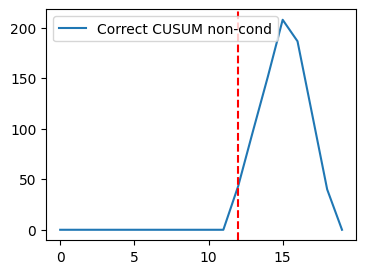

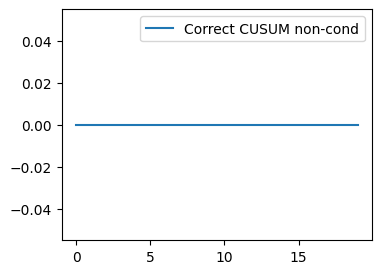

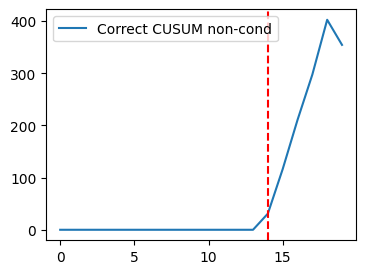

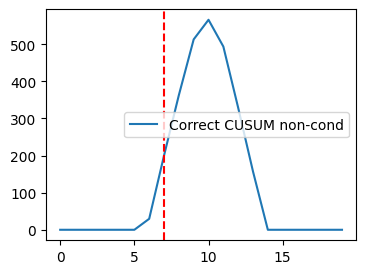

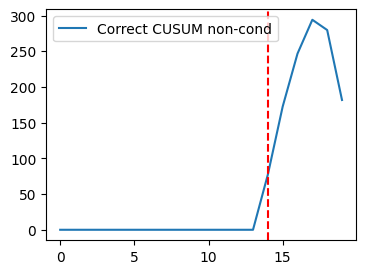

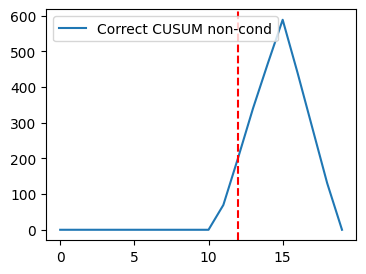

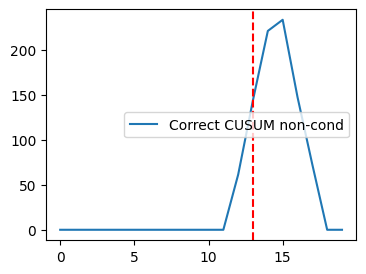

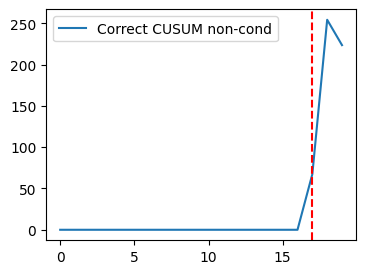

In [23]:
ens_bce_correct_noncond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="correct",
    conditional=False,
    #lambda_null=lambda_null,
    #lambda_inf=lambda_inf,
    half_wnd=1,
)
ens_bce_correct_noncond.load_models_list(path_to_models_folder)

_ = ens_bce_correct_noncond.predict(seq_batch)
cusum_correct_noncond = ens_bce_correct_noncond.normal_to_change_stats.detach().cpu()

for IDX in range(8):
    change_idx = labels_batch[IDX].detach().cpu().numpy().argmax()

    plt.figure(figsize=(4, 3))
    plt.plot(cusum_correct_noncond[IDX], label="Correct CUSUM non-cond")

    if change_idx > 0:
        plt.axvline(x = change_idx, c="red", linestyle="--")
    plt.legend()
    plt.show()

In [24]:
cusum_threshold_list = np.linspace(0, 500, 300)

metrics.evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="correct",
    conditional=False,
    global_sigma=global_sigma,
    #lambda_null=lambda_null,
    #lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 300/300 [11:30<00:00,  2.30s/it]


Results for best threshold = 76.92307692307692
AUDC: 0.0, Time to FA: 10.8078, DD: 1.3059, F1: 0.9244, Cover: 0.8894, Max Cover: 0.8894
Max F1 with margin 1: 0.7443
Max F1 with margin 2: 0.8795
Max F1 with margin 4: 0.9307


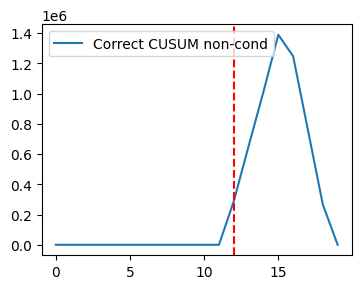

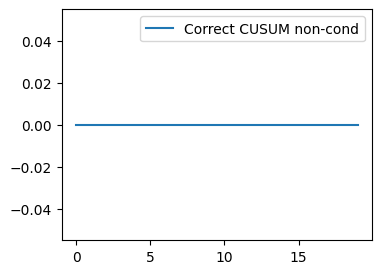

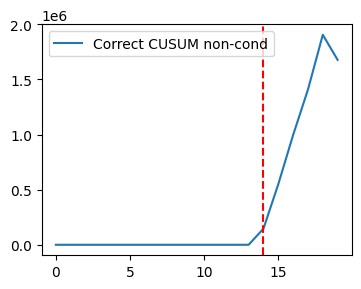

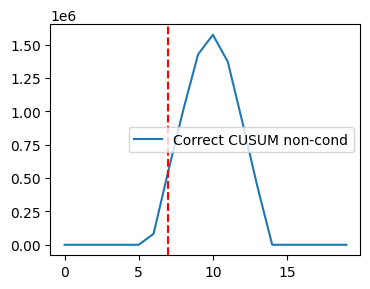

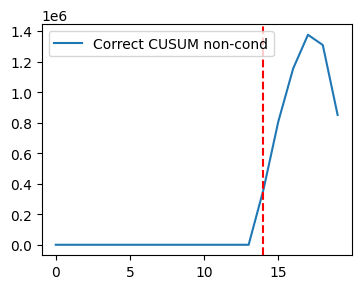

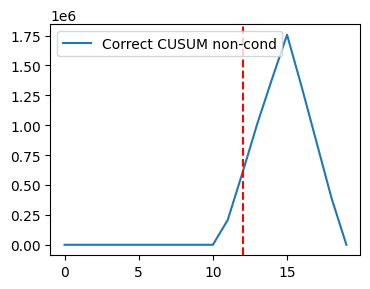

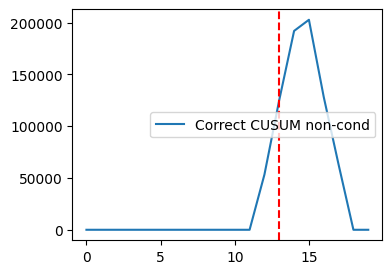

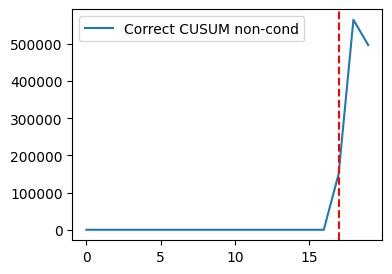

In [15]:
global_sigma = "local_start"

ens_bce_correct_noncond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="correct",
    conditional=False,
    #lambda_null=lambda_null,
    #lambda_inf=lambda_inf,
    half_wnd=1,
)
ens_bce_correct_noncond.load_models_list(path_to_models_folder)

_ = ens_bce_correct_noncond.predict(seq_batch)
cusum_correct_noncond = ens_bce_correct_noncond.normal_to_change_stats.detach().cpu()

for IDX in range(8):
    change_idx = labels_batch[IDX].detach().cpu().numpy().argmax()

    plt.figure(figsize=(4, 3))
    plt.plot(cusum_correct_noncond[IDX], label="Correct CUSUM non-cond")

    if change_idx > 0:
        plt.axvline(x = change_idx, c="red", linestyle="--")
    plt.legend()
    plt.show()

In [27]:
cusum_threshold_list = np.linspace(0, 1000, 50)

metrics.evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="correct",
    conditional=False,
    global_sigma=global_sigma,
    #lambda_null=lambda_null,
    #lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 50/50 [01:55<00:00,  2.31s/it]

Results for best threshold = 0.0
AUDC: 0.0, Time to FA: 10.0396, DD: 0.371, F1: 0.8639, Cover: 0.9313, Max Cover: 0.9313
Max F1 with margin 1: 0.9085
Max F1 with margin 2: 0.9312
Max F1 with margin 4: 0.9394


In [16]:
norm_sigma = 0.01384
cp_sigma = 0.18081

global_sigma = "local_whole"

lambda_null = 1. / cp_sigma ** 2
#lambda_inf = 1. / norm_sigma ** 2
lambda_inf = None

half_wnd = 1

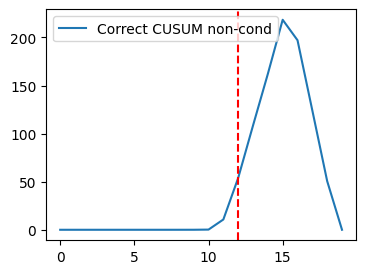

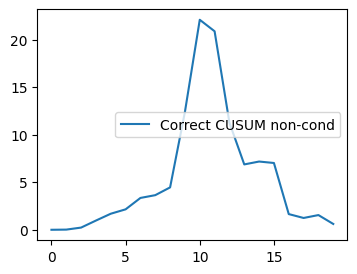

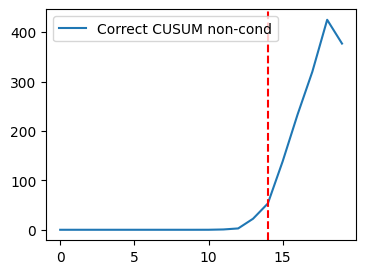

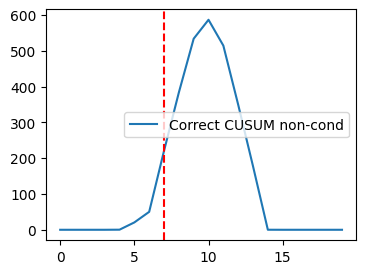

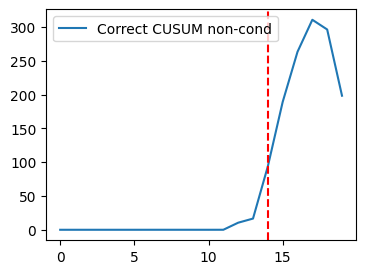

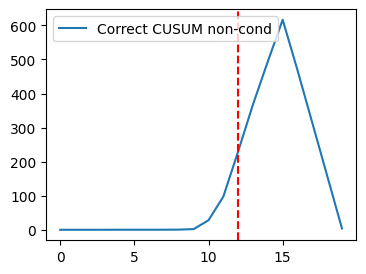

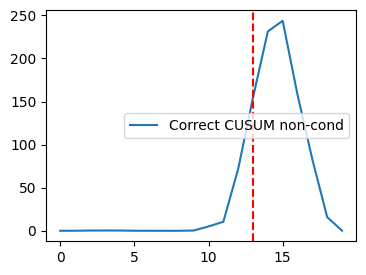

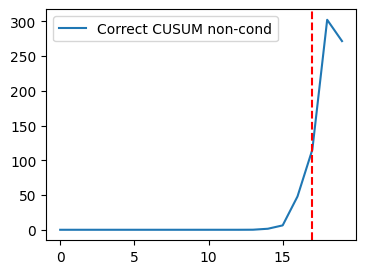

In [17]:
ens_bce_correct_noncond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="new_criteria",
    conditional=False,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=1,
)
ens_bce_correct_noncond.load_models_list(path_to_models_folder)

_ = ens_bce_correct_noncond.predict(seq_batch)
cusum_correct_noncond = ens_bce_correct_noncond.normal_to_change_stats.detach().cpu()

for IDX in range(8):
    change_idx = labels_batch[IDX].detach().cpu().numpy().argmax()

    plt.figure(figsize=(4, 3))
    plt.plot(cusum_correct_noncond[IDX], label="Correct CUSUM non-cond")

    if change_idx > 0:
        plt.axvline(x = change_idx, c="red", linestyle="--")
    plt.legend()
    plt.show()

In [18]:
cusum_threshold_list = np.linspace(0, 1000, 300)

metrics.evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="new_criteria",
    conditional=False,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 300/300 [11:37<00:00,  2.32s/it]

Results for best threshold = 96.98996655518394
AUDC: 0.0, Time to FA: 10.7823, DD: 1.288, F1: 0.9241, Cover: 0.8886, Max Cover: 0.8886
Max F1 with margin 1: 0.7521
Max F1 with margin 2: 0.8855
Max F1 with margin 4: 0.94


# BCE Explosion

In [19]:
model_type = "seq2seq"
experiments_name = "explosion"

path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"

with open(path_to_config, 'r') as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["loss_type"] = "bce"
args_config["num_workers"] = 2
args_config["learning"]["gpus"] = 1
args_config["learning"]["epochs"] = 100

In [33]:
path_to_models_folder = "saved_models/bce/explosion/layer_norm/train_anomaly_num_155"

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

test_dataset = ens_bce.test_dataset
test_dataloader = DataLoader(test_dataset, batch_size=40, shuffle=True)

seq_batch, labels_batch = next(iter(test_dataloader))
seq_batch = seq_batch.to("cuda")

In [24]:
# collecting outputs
test_out_bank, test_uncertainties_bank, test_labels_bank = metrics.collect_model_predictions_on_set(
    ens_bce,
    test_dataloader,
    model_type="ensemble",
    device="cuda"
)

out_dataset = OutputDataset(test_out_bank, test_uncertainties_bank, test_labels_bank)
out_dataloader = DataLoader(out_dataset, batch_size=128, shuffle=False)

(preds, stds), labels = out_dataset[0]
preds.shape, stds.shape, labels.shape

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [03:11<00:00,  9.57s/it]


(torch.Size([16]), torch.Size([16]), torch.Size([16]))

In [25]:
metrics.compute_stds(
    ens_bce,
    test_dataloader,
    windows_list=[1, 2, 3, 4],
    verbose=True,
    device="cuda"
);

  0%|          | 0/20 [00:00<?, ?it/s]

Computing model's outputs...


100%|██████████| 20/20 [03:14<00:00,  9.71s/it]


Window: 1
CP stds list:
Mean = 0.11665003622571628, number is 15
Normal stds list:
Mean = 0.06306435348121983, number is 314
p_val analytical = 0.034268675717469076, p_val permutational = 0.1053
No conclusion
--------------------------------------------------
Window: 2
CP stds list:
Mean = 0.11403134812911352, number is 15
Normal stds list:
Mean = 0.06278549496582739, number is 314
p_val analytical = 0.039576283178545967, p_val permutational = 0.1152
No conclusion
--------------------------------------------------
Window: 3
CP stds list:
Mean = 0.11378828560312589, number is 15
Normal stds list:
Mean = 0.06252868208369822, number is 314
p_val analytical = 0.03574880071351207, p_val permutational = 0.1119
No conclusion
--------------------------------------------------
Window: 4
CP stds list:
Mean = 0.11107935880621274, number is 15
Normal stds list:
Mean = 0.06229435333946518, number is 314
p_val analytical = 0.037349090459049474, p_val permutational = 0.1137
No conclusion
------------

In [26]:
#norm_sigma = 0.0164996
#cp_sigma = 0.032072

global_sigma = "local_start"

#lambda_null = 1. / cp_sigma ** 2
#lambda_inf = 1. / norm_sigma ** 2
#lambda_inf = None

half_wnd = 1

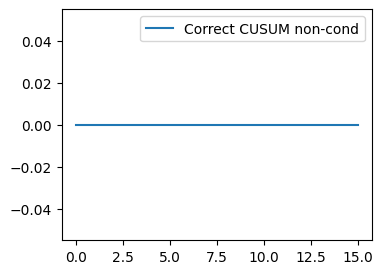

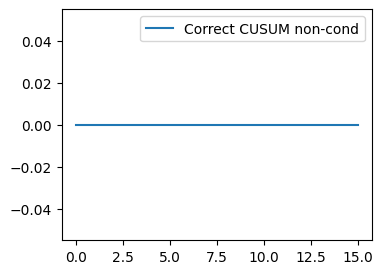

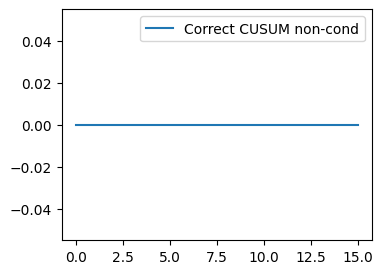

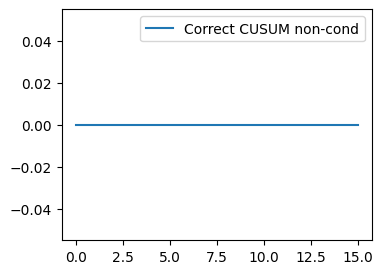

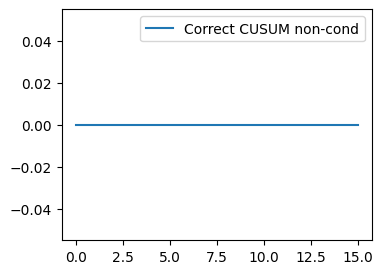

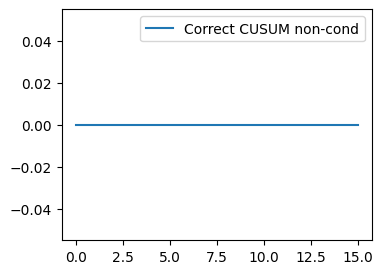

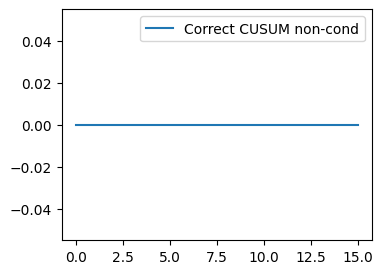

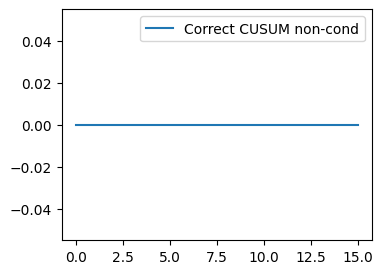

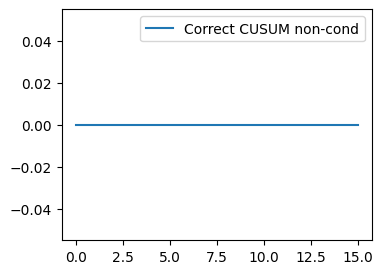

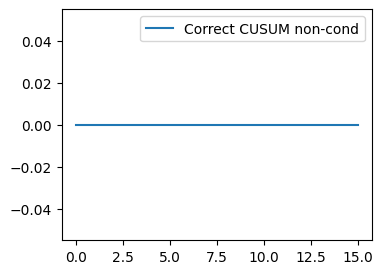

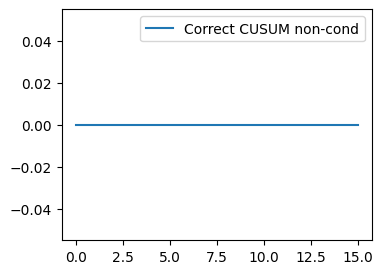

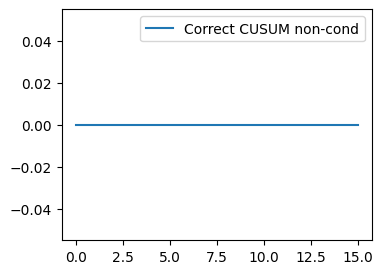

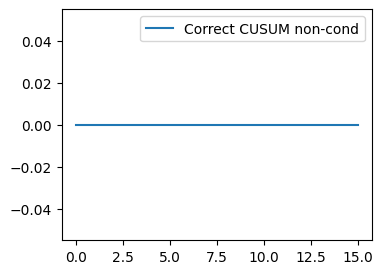

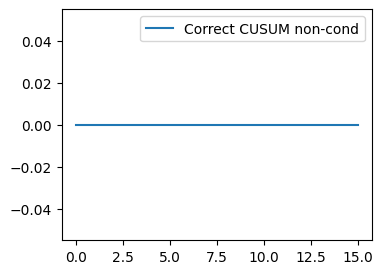

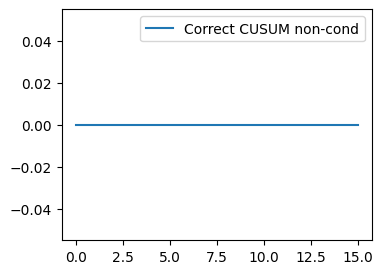

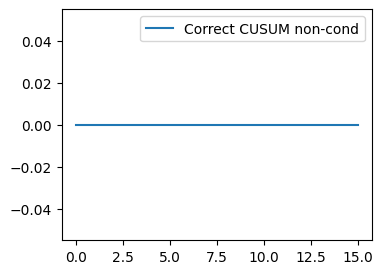

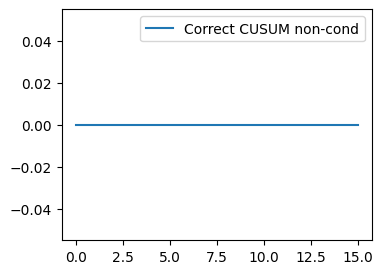

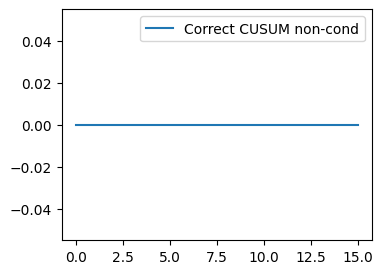

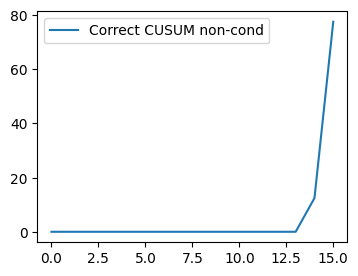

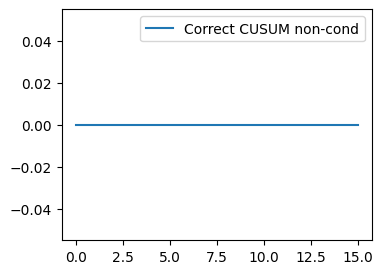

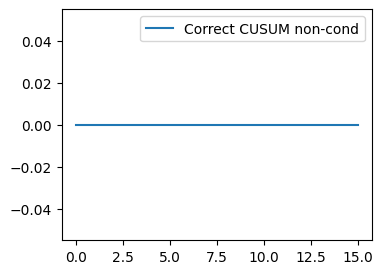

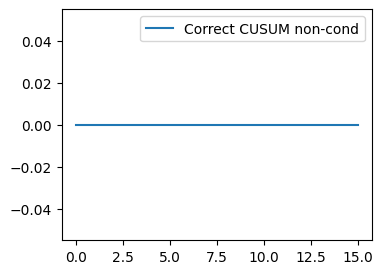

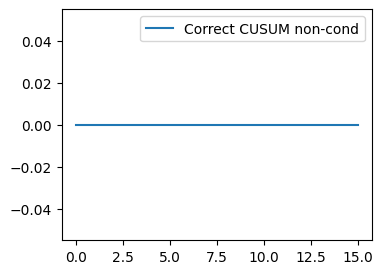

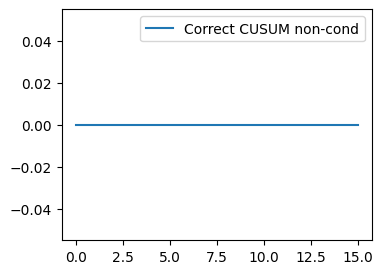

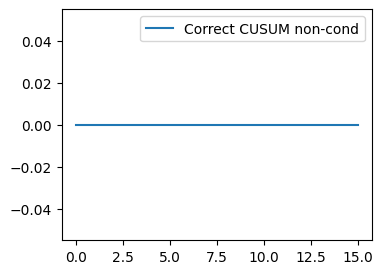

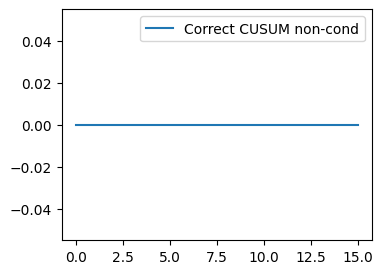

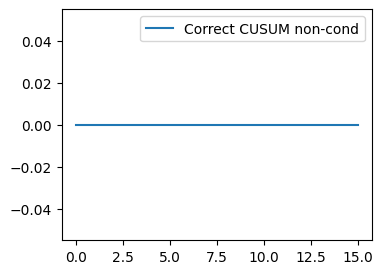

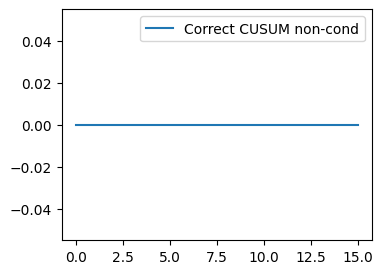

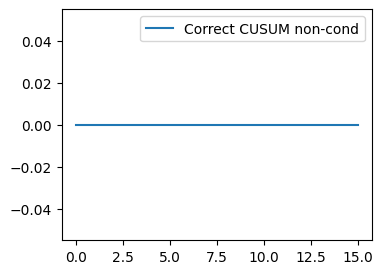

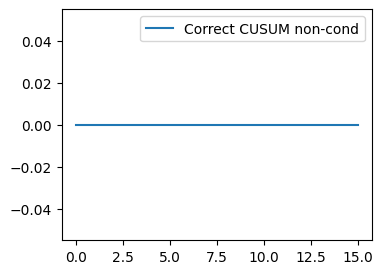

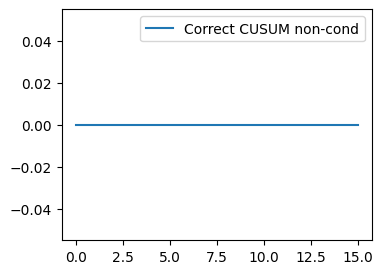

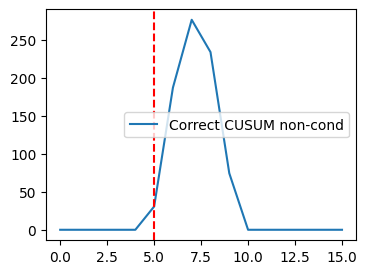

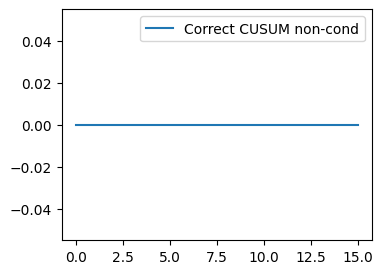

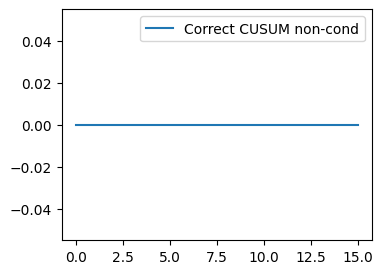

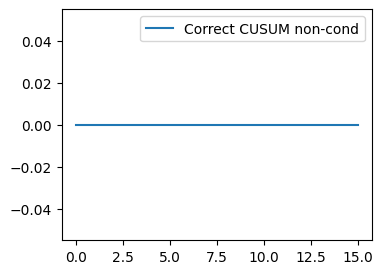

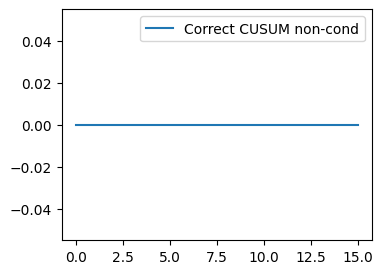

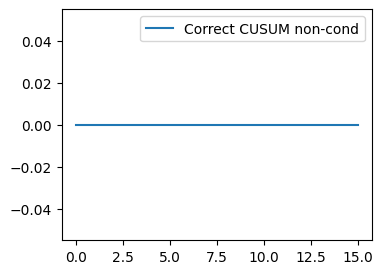

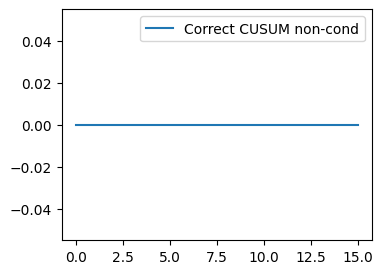

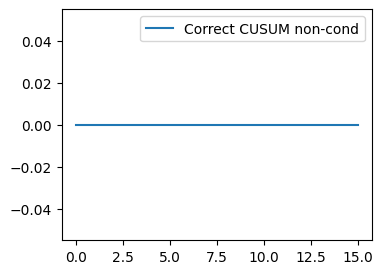

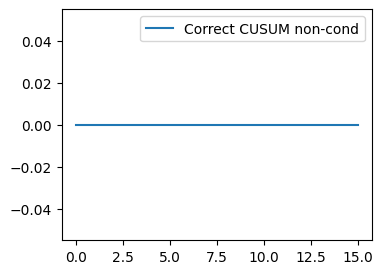

In [35]:
ens_bce_correct_noncond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="correct",
    conditional=False,
    #lambda_null=lambda_null,
    #lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_bce_correct_noncond.load_models_list(path_to_models_folder)
ens_bce_correct_noncond.to("cuda")

_ = ens_bce_correct_noncond.predict(seq_batch)
cusum_correct_noncond = ens_bce_correct_noncond.normal_to_change_stats.detach().cpu()

for IDX in range(40):
    change_idx = labels_batch[IDX].detach().cpu().numpy().argmax()

    plt.figure(figsize=(4, 3))
    plt.plot(cusum_correct_noncond[IDX], label="Correct CUSUM non-cond")

    if change_idx > 0:
        plt.axvline(x = change_idx, c="red", linestyle="--")
    plt.legend()
    plt.show()

In [37]:
cusum_threshold_list = np.linspace(0, 500, 200)

metrics.evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="correct",
    conditional=False,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

  0%|          | 0/200 [00:00<?, ?it/s]Exception ignored in: <function tqdm.__del__ at 0x7fc4525c7f70>
Traceback (most recent call last):
  File "/home/indid/miniconda/envs/env/lib/python3.9/site-packages/tqdm/std.py", line 1127, in __del__
    def __del__(self):
KeyboardInterrupt: 
  1%|          | 2/200 [00:14<24:35,  7.45s/it]


KeyboardInterrupt: 